# Capital One Data Science Challenge

**Note**: 
- This notebook was distributed into four sections in order to answer the four required questions.
- I worked in Google Colab with GPU-acceleration for this task. 

## Table of Contents:

* [Question 1: Load](#first-bullet)
   - [Summary of Question 1](#sub1)

* [Question 2: Plot](#second-bullet)
  - [Summary of Question 2](#sub2)

* [Question 3: Data Wrangling - Duplicate Transactions](#third-bullet)
  - [I. Reversed transactions](#sub3)
  - [II: Multi-swipe transactions](#sub4)
  - [III: Additional analysis about either kind of transaction](#sub5)
  - [Summary of Question 3](#sub6)
  
* [Question 4: Model](#fourth-bullet)
  - [I: Feature Engineering](#sub7)
  - [II: Build the classification model -- XGBoost](#sub8)
  - [Summary of Question 3](#sub9)
  
* [Appendix of Question 4: Future work](#fifth-bullet)

In [1]:
# ! pip install optuna

In [2]:
# load all pkgs

# general libraries
import sys, os, shutil
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from datetime import datetime, date
import warnings
warnings.simplefilter(action='ignore')

# file management
import zipfile
import json

# plotting libraries
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

# machine learning libraries
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, recall_score, accuracy_score, precision_score
import xgboost as xgb
from xgboost import plot_importance

# optimization libraries
import optuna

In [3]:
print(sys.version)

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]


## Question 1: Load <a class="anchor" id="first-bullet"></a>

- Programmatically download and load into your favorite analytical tool the transactions data. This data is in line-delimited JSON format
- Please describe the structure of the data. Number of records and fields in each record?
- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [4]:
! pwd

/content


In [5]:
# download the dataset to current directory

! git clone https://github.com/CapitalOneRecruiting/DS.git

fatal: destination path 'DS' already exists and is not an empty directory.


In [6]:
# Extract zip file contents

with zipfile.ZipFile('./DS/transactions.zip', 'r') as zip_tran:
    # show files inside the zip folder
    zip_tran.printdir()  
    # extract the .txt file from the zip folder
    zip_tran.extractall()
    print('File extracted.')

File Name                                             Modified             Size
transactions.txt                               2020-01-07 21:32:42    609937737
File extracted.


In [7]:
%%time

# A memory-effective way to load the json format data into DataFrame
file_list = []  # initialize a list container
with open('transactions.txt', 'r') as json_tran:
    for line in json_tran:
        tran_data = json.loads(line)  # load each line-delimited JSON format data
        file_list.append(tran_data)
    print("File loading finished.")

# transfer to dataframe
df = pd.DataFrame(file_list)

File loading finished.
CPU times: user 14 s, sys: 1.58 s, total: 15.6 s
Wall time: 15.5 s


In [8]:
# df to csv for reuse
# in principle, we should always keep an original version of dataset. However for this work, 
# I'll use the loaded df for any following analysis in order to save memory usage

# df.to_csv('./c1_credit_transaction.csv', index=False)
# df = pd.read_csv('./c1_credit_transaction.csv', keep_default_na=False)

In [9]:
# describe the structure of the data; number of records and fields in each record

print(f"The total number of records = {df.shape[0]}; the total number of fields = {df.shape[1]}.")
# print()
# print(f"Those fields are: {df.columns}.")

The total number of records = 786363; the total number of fields = 29.


In [10]:
# explore the type of each fields as printout above

def fields_type_classifier(df):
    """ Helper function to classify the type of fields for a given df into three categories:
    numeric(e.g. float64), bool, or object(e.g. string information).
    Params:
        df: dataframe object
    Return:
        fields_o_list, fields_b_list, fields_n_list: lists of three field categories
    """
    fields_o_list = []  # list object to store fields classified as 'object'
    fields_b_list = []  # list object to store fields classified as boolen value
    fields_n_list = []  # list object to store fields classified as float
    
    # begin classification
    for field in df.columns:
        if df[field].dtype == 'O':
            fields_o_list.append(field)
        elif df[field].dtype == 'bool':
            fields_b_list.append(field)
        elif df[field].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
            fields_n_list.append(field)
        else:
            raise Exception(f"The field {field} can't be classified as any type!")
            
    # final check of results
    if len(fields_o_list) + len(fields_b_list) + len(fields_n_list) == len(df.columns):
        print("All fields were classified.")
        
    return fields_o_list, fields_b_list, fields_n_list

In [11]:
fields_o_list, fields_b_list, fields_n_list = fields_type_classifier(df)
print()
print(f"1. Fields classified as 'object' type are: {fields_o_list}.")
print("---------------------------------------------------------------------------------------------------------")
print(f"2. Fields classified as 'numeric' type are: {fields_n_list}.")
print("---------------------------------------------------------------------------------------------------------")
print(f"3. Fields classified as 'bool' type are: {fields_b_list}.")

All fields were classified.

1. Fields classified as 'object' type are: ['accountNumber', 'customerId', 'transactionDateTime', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'].
---------------------------------------------------------------------------------------------------------
2. Fields classified as 'numeric' type are: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'].
---------------------------------------------------------------------------------------------------------
3. Fields classified as 'bool' type are: ['cardPresent', 'expirationDateKeyInMatch', 'isFraud'].


In [12]:
# check the unique values of the df
# here base on domain knowledge, It is hypothesized that two fields accountNumber or customerId 
# should be the primary key

print(f"The total number of unique id in the dataset = {df.accountNumber.nunique()} by accountNumber.")
print(f"The total number of unique id in the dataset = {df.customerId.nunique()} by customerId.")

The total number of unique id in the dataset = 5000 by accountNumber.
The total number of unique id in the dataset = 5000 by customerId.


In [13]:
# show the top 5 records of the df
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [14]:
# check the missing value condition in each field
for field in df.columns:
    print(f"Field {field} has missing value number = {df[field].isnull().sum()}.")

Field accountNumber has missing value number = 0.
Field customerId has missing value number = 0.
Field creditLimit has missing value number = 0.
Field availableMoney has missing value number = 0.
Field transactionDateTime has missing value number = 0.
Field transactionAmount has missing value number = 0.
Field merchantName has missing value number = 0.
Field acqCountry has missing value number = 0.
Field merchantCountryCode has missing value number = 0.
Field posEntryMode has missing value number = 0.
Field posConditionCode has missing value number = 0.
Field merchantCategoryCode has missing value number = 0.
Field currentExpDate has missing value number = 0.
Field accountOpenDate has missing value number = 0.
Field dateOfLastAddressChange has missing value number = 0.
Field cardCVV has missing value number = 0.
Field enteredCVV has missing value number = 0.
Field cardLast4Digits has missing value number = 0.
Field transactionType has missing value number = 0.
Field echoBuffer has miss

**My comment**: The missing value checking results above is clearly against my initial observation of the dataframe. Some fields (e.g. merchantCity, merchantState, merchantZip) contain "null value" according to the top five records of the dataframe. It is hypothesized that those "null value" are stored as ""(a.k.a. empty string ) format in the dataframe. Thus for next step, I'll replace those empty strings by NaN value.

In [15]:
# Apply replacement of the empty strings by NaNs
for field in df.columns:
    df[field] = df[field].map(lambda x: np.nan if x =='' else x)
print("NaNs replacement done.")

NaNs replacement done.


In [16]:
# let do a second round of missing value checking

fields_wo_mv_list = []  # fields without missing value
fields_w_mv_list = []  # fields with some missing value
fields_all_mv_list = []  # fields totally empty

for field in df.columns:
    if df[field].isnull().sum() == 0:
        fields_wo_mv_list.append(field)
    elif df[field].isnull().sum() > 0 and df[field].isnull().sum() < df.shape[0]:
        fields_w_mv_list.append(field)
    else:
        fields_all_mv_list.append(field)
    print(f"Field {field} has missing value number = {df[field].isnull().sum()}.")

Field accountNumber has missing value number = 0.
Field customerId has missing value number = 0.
Field creditLimit has missing value number = 0.
Field availableMoney has missing value number = 0.
Field transactionDateTime has missing value number = 0.
Field transactionAmount has missing value number = 0.
Field merchantName has missing value number = 0.
Field acqCountry has missing value number = 4562.
Field merchantCountryCode has missing value number = 724.
Field posEntryMode has missing value number = 4054.
Field posConditionCode has missing value number = 409.
Field merchantCategoryCode has missing value number = 0.
Field currentExpDate has missing value number = 0.
Field accountOpenDate has missing value number = 0.
Field dateOfLastAddressChange has missing value number = 0.
Field cardCVV has missing value number = 0.
Field enteredCVV has missing value number = 0.
Field cardLast4Digits has missing value number = 0.
Field transactionType has missing value number = 698.
Field echoBuf

In [17]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [18]:
# show the basic summary statistics for numeric fields
df.describe(include=[np.number])

,creditLimit,availableMoney,transactionAmount,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363.000000,786363.000000,786363.000000,0.0,786363.000000,0.0,0.0,0.0,0.0,0.0
mean,10759.464459,6250.725369,136.985791,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN
std,11636.174890,8880.783989,147.725569,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN
min,250.000000,-1005.630000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
25%,5000.000000,1077.420000,33.650000,NaN,689.910000,NaN,NaN,NaN,NaN,NaN
50%,7500.000000,3184.860000,87.900000,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN
75%,15000.000000,7500.000000,191.480000,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN
max,50000.000000,50000.000000,2011.540000,NaN,47498.810000,NaN,NaN,NaN,NaN,NaN


In [19]:
# finally, it's in curious to check if the dataset is imbalanced based on the target field isFraud

print(f"The number of records labeled as NOT fraud = {sum(df.isFraud == False)}.")
print(f"Percent of NOT fraud records = {np.round(sum(df.isFraud == False)/786363, decimals=4)}.")
print(f"The number of records labeled as fraud = {sum(df.isFraud == True)}.")
print(f"Percent of fraud records = {np.round(sum(df.isFraud == True)/786363, decimals=4)}.")

The number of records labeled as NOT fraud = 773946.
Percent of NOT fraud records = 0.9842.
The number of records labeled as fraud = 12417.
Percent of fraud records = 0.0158.


### Summary of Question 1: <a class="anchor" id="sub1"></a>

**I: Structure of the data**:
- For the whole dataframe of **786363** records and **29** fields, 22 fields were classified as 'object' type feature; 4 fields were classified as 'numeric' type feature; 3 fields were classified as 'bool' type feature. The bool feature **isFraud** is our prediction target.

**II: Basic summary statistics**:
- The total number of unique id in the dataset = 5000.


- Based on my missing value analysis:
    - **18 fields**: 'accountNumber', 'customerId', 'creditLimit', 'availableMoney', 'transactionDateTime', 'transactionAmount', 'merchantName', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud' have no null value (clean fields)
    - **5 fields**: 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType' contain partial null value (partially clean fields) -- *Need to perform fillna*.
    - **6 fields**: 'echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd' are totally empty (with no record) -- *Need to be dropped*.
    
    
- Among the 4 fields with summary statistics:
    - **creditLimit**: the maximum credit limit is \\$50000; the minimum credit limit is \\$250; the average credit limit is \\$10759.464459. Since the 50\% quantile located at \\$7500, the distribution of creditLimit field is highly right skew. 
    - **availableMoney**: the maximum available money is \\$50000; the minimum available money is \\$-1005.63; the average available money is \\$6250.725369. Since the 50\% quantile located at \\$3184.86, the distribution of availableMoney field is highly right skew. 
    - **transactionAmount**: the maximum transaction amount is \\$2011.54; the minimum transaction amount is \\$0; the average transaction amount is \\$136.985791. Since the 50\% quantile located at \\$87.9, the distribution of transactionAmount field is highly right skew. 
    - **currentBalance**: the maximum current balance is \\$47498.81; the minimum current balance is \\$0; the average current balance is \\$4508.739089. Since the 50\% quantile located at \\$2451.76, the distribution of currentBalance field is highly right skew. 
    
    
- Based on the distribution of records with True or False labels of 'isFraud', **the whole dataset is highly imbalanced.**

## Question 2: Plot <a class="anchor" id="second-bullet"></a>

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
- Report any structure you find and any hypotheses you have about that structure.

**My hypotheses**: as mentioned in the above summary of Question 1, the field transactionAmount should be in form of **right skewed distribution**. 

Text(0.5, 1.0, 'Histogram of the transactionAmount Field')

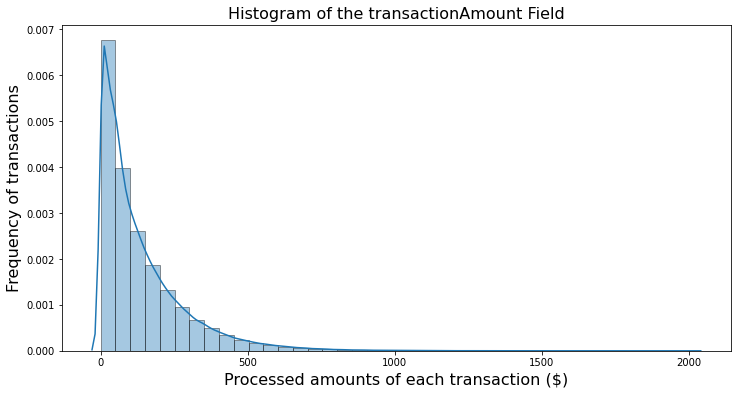

In [20]:
# Plot a OVERALL histogram of the transactionAmount column

target_col = 'transactionAmount'
plt.figure(figsize=(12, 6))
sns.distplot(df[target_col], color=next(palette), hist=True, kde=True, 
             bins=40, hist_kws={'edgecolor':'black'})

plt.xlabel("Processed amounts of each transaction ($)", size=16)
plt.ylabel('Frequency of transactions', size=16)
plt.title('Histogram of the transactionAmount Field', size=16)

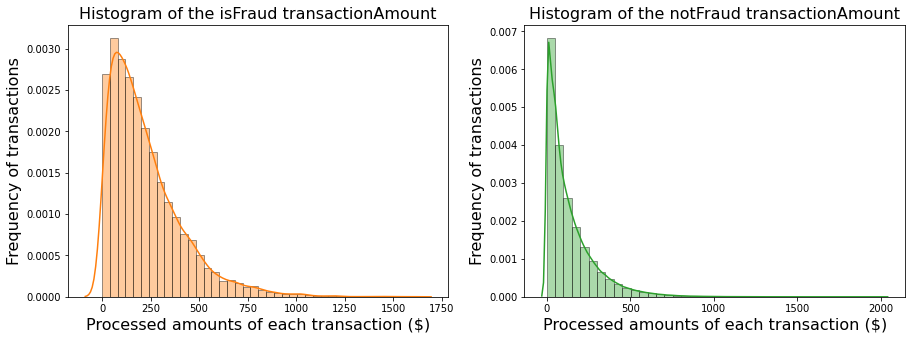

In [21]:
# Next, regarding to any structure that I find interesting, it's in curious to bridge the transactionAmount field 
# with our target field isFraud

# slicing the targeting pd series
series_tran_isFraud = df.loc[df.isFraud==True, target_col]
series_tran_notFraud = df.loc[df.isFraud==False, target_col]

# make a subplot based on binary isFraud
plt.figure(figsize=(15, 5))
for (i, series_tran), label in zip(enumerate([series_tran_isFraud, series_tran_notFraud]), \
                                   ['isFraud', 'notFraud']):
    plt.subplot(1, 2, i+1)
    sns.distplot(series_tran, color=next(palette), hist=True, kde=True, 
             bins=40, hist_kws={'edgecolor':'black'})
    plt.xlabel("Processed amounts of each transaction ($)", size=16)
    plt.ylabel('Frequency of transactions', size=16)
    plt.title(f'Histogram of the {label} transactionAmount', size=16)

In [22]:
# provide the summary statistics of notFraud and isFraud type of transactionAmount field

print(f"Summary of isFraud transactionAmount data: {series_tran_isFraud.describe()}")
print("------------------------------------------------------------------------------")
print(f"Summary of notFraud transactionAmount data: {series_tran_notFraud.describe()}")

Summary of isFraud transactionAmount data: count    12417.000000
mean       225.215905
std        189.551393
min          0.000000
25%         86.000000
50%        176.980000
75%        311.460000
max       1608.350000
Name: transactionAmount, dtype: float64
------------------------------------------------------------------------------
Summary of notFraud transactionAmount data: count    773946.000000
mean        135.570249
std         146.525305
min           0.000000
25%          33.190000
50%          86.760000
75%         189.390000
max        2011.540000
Name: transactionAmount, dtype: float64


### Summary of Question 2: <a class="anchor" id="sub2"></a>

1. It's proved that my initial hypotheses were supported by the overall plot of the transactionAmount field: the overall distribution of transaction amount is heavily right-skewed, which indicates majority of records took the form of **small transactions**.


2. According to the shape of distribution of `notFraud` and `isFraud` transactions, we can see the normal transaction distribution is more right-skewed than fraud transaction distribution, which means fraud transactions are more tend to take in form with relatively larger transaction amount. This conclusion is also supported by the summary statistics.


3. From the summary statistics, fraud transaction amount has mean of \\$225.216, whereas the normal transaction amount has mean of \\$135.57. smaller than the former; On the other hand, fraud transaction amount has maximum amount of \\$1608.35, whereas the normal transaction amount has maximum amount of \\$2011.54, which is much larger than the former. It might indicates the fraud transactions could take the form of relatively higher amount followed with multiple-time transactions. 

## Question 3: Data Wrangling - Duplicate Transactions <a class="anchor" id="third-bullet"></a>

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

### I. Reversed transactions <a class="anchor" id="sub3"></a>

- I'll look into the transactionType field to identify if reversed or multi-swipe transactions were labeled
- Before that, since transactionType field contains 698 rows of missing value, I'll fillna with "NaN" keywords

In [23]:
# fillna with "NaN" and perform value counts for transactionType field

df['transactionType'] = df['transactionType'].fillna('NaN')
df['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
NaN                        698
Name: transactionType, dtype: int64

In [24]:
# only REVERSAL type transactions were labeled
# extract the df of REVERSAL type transactions

df_reversal = df.loc[df.transactionType=='REVERSAL']
print(f"The total number of REVERSAL type transactions = {df_reversal.shape[0]}.")
df_reversal.head(3)

The total number of REVERSAL type transactions = 20303.


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
39,574788567,574788567,2500.0,2200.98,2016-05-24T01:38:03,215.13,Convenient Tire,US,US,09,01,auto,10/2021,2015-10-13,2015-10-13,206,206,8522,REVERSAL,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
73,574788567,574788567,2500.0,2432.72,2016-10-07T10:23:57,3.87,Eazy Repair,US,US,05,01,auto,10/2022,2015-10-13,2015-10-13,579,579,4219,REVERSAL,NaN,67.28,NaN,NaN,NaN,True,NaN,NaN,False,False
101,924729945,924729945,50000.0,49831.43,2016-10-19T14:01:45,168.57,discount.com,US,US,05,01,online_retail,11/2024,2014-07-25,2014-07-25,205,265,9459,REVERSAL,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False


In [25]:
# Report the total dollar amount of REVERSAL type transactions based on sum of transactionAmount

tot_reversal_amount = df_reversal['transactionAmount'].sum(axis=0)
print(f"The total dollar amount of REVERSAL type transactions = {tot_reversal_amount}.")

The total dollar amount of REVERSAL type transactions = 2821792.5.


### II: Multi-swipe transactions <a class="anchor" id="sub4"></a>

- Based on the nature of multi-swipe transactions, the five fields: **accountNumber, customerId, transactionAmount, merchantName, cardLast4Digits** should be exactly the same (other fields, e.g. merchantCountryCode could also be the same for multi-swipe transactions, but this level of information is too general to make inferences). Thus, we can group these fields to identify multi-swipe transactions. 
- Noted that short time span is also an important character to identify multi-swipe transactions. Thus, I'll use the **transactionDateTime** field to exclude those valid multi-swipe transactions.

**Note**: 
- There are still missing value exist in the transactionType field, so I'll temporarily add those missing records into annlysis.
- Since the transactionDateTime field is still in its raw format, I'll process the field with a valid datetime.

In [26]:
# Processing the transactionDateTime field with standard datetime
df['transactionDateTime'] = df['transactionDateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [27]:
# extract the df of PURCHASE type transactions as well as missing type transactions
df_purchase = df.loc[(df.transactionType=='PURCHASE') | (df.transactionType=='NaN')]
print(f"The total number of purchase and missing type transactions = {df_purchase.shape[0]}.")

The total number of purchase and missing type transactions = 745891.


In [28]:
# count the amount of total distinct transactions based on 
fields_list = ['accountNumber', 'customerId','merchantName', 'transactionAmount', 'cardLast4Digits']
df_purchase_group = df_purchase.groupby(fields_list).size().reset_index(name='repeat')

# find transactions with multiple repetitive fields
df_purchase_group_multi = df_purchase_group.loc[df_purchase_group.repeat>1]

# find intersection of the total purchase df(df_purchase) and the suspect 
# multi-swipe df(df_purchase_group_multi)
df_purchase_multi = pd.merge(df_purchase_group_multi, df_purchase, how='inner', on=fields_list)

In [29]:
# processing with transaction time difference in seconds

# in case, sort based on transactionDateTime within records of same suspect multi-swipe transactions
df_purchase_multi_sort = df_purchase_multi.sort_values(by=['accountNumber', 'customerId',
                                                       'merchantName', 'transactionAmount', 
                                                       'cardLast4Digits', 'transactionDateTime'])

# initialize tranDateTimeDiff field to assign running time diff, default first record to be 0
df_purchase_multi_sort['tranDateTimeDiff'] = 0

# loop through the transactionDateTime field to calculate time diff in seconds
for i in range(df_purchase_multi_sort.shape[0]-1):
    df_purchase_multi_sort['tranDateTimeDiff'][i+1] = (
        df_purchase_multi_sort['transactionDateTime'][i+1] - 
        df_purchase_multi_sort['transactionDateTime'][i]).total_seconds()

In [30]:
# define the short time period as 3 minutes (180 seconds)
time_diff_threshold = 180  # in seconds
df_multi_swipe = df_purchase_multi_sort.loc[(df_purchase_multi_sort.tranDateTimeDiff<time_diff_threshold) &
                                            (df_purchase_multi_sort.tranDateTimeDiff>0)]

print(f"The total number of Multi-swipe type transactions = {df_multi_swipe.shape[0]}.")
df_multi_swipe.head()

The total number of Multi-swipe type transactions = 7457.


,accountNumber,customerId,merchantName,transactionAmount,cardLast4Digits,repeat,creditLimit,availableMoney,transactionDateTime,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,tranDateTimeDiff
9,100088067,100088067,Fresh Flowers,411.35,2077,2,50000.0,49275.09,2016-10-16 18:01:02,US,US,02,08,online_gifts,12/2019,2014-01-09,2014-01-09,402,402,PURCHASE,NaN,724.91,NaN,NaN,NaN,False,NaN,NaN,False,False,2
43,100737756,100737756,34th BBQ #166379,43.25,4317,2,250.0,177.98,2016-07-10 14:32:06,US,US,02,01,food,03/2029,2015-06-21,2015-06-21,463,463,PURCHASE,NaN,72.02,NaN,NaN,NaN,True,NaN,NaN,False,False,59
45,100737756,100737756,Franks Deli,693.50,4317,3,250.0,-44.75,2016-01-18 01:55:28,US,US,05,01,food,03/2025,2015-06-21,2015-06-21,463,463,PURCHASE,NaN,294.75,NaN,NaN,NaN,True,NaN,NaN,False,False,4
46,100737756,100737756,Franks Deli,693.50,4317,3,250.0,-535.03,2016-01-18 01:58:26,US,US,05,01,food,03/2025,2015-06-21,2015-06-21,463,463,PURCHASE,NaN,785.03,NaN,NaN,NaN,True,NaN,NaN,False,False,178
48,100737756,100737756,South Steakhouse #73819,211.22,4317,2,250.0,250.00,2016-07-02 12:07:00,US,US,09,01,food,02/2033,2015-06-21,2015-06-21,463,463,PURCHASE,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False,116


In [31]:
# Report the total dollar amount of Multi-swipe type transactions based on sum of transactionAmount

tot_multi_swipe_amount = df_multi_swipe['transactionAmount'].sum(axis=0)
print(f"The total dollar amount of Multi-swipe type transactions = {tot_multi_swipe_amount}.")

The total dollar amount of Multi-swipe type transactions = 1104006.71.


### III: Additional analysis about either kind of transaction <a class="anchor" id="sub5"></a>

- It's in curious to visualize the transactionAmount field distributions of both reveral and multi-swipe type transactions with our target field `isFraud`.
- Explore the percentage of Fraud transactions happened in both reveral and multi-swipe type transactions based on merchant categories (`merchantCategoryCode` field)

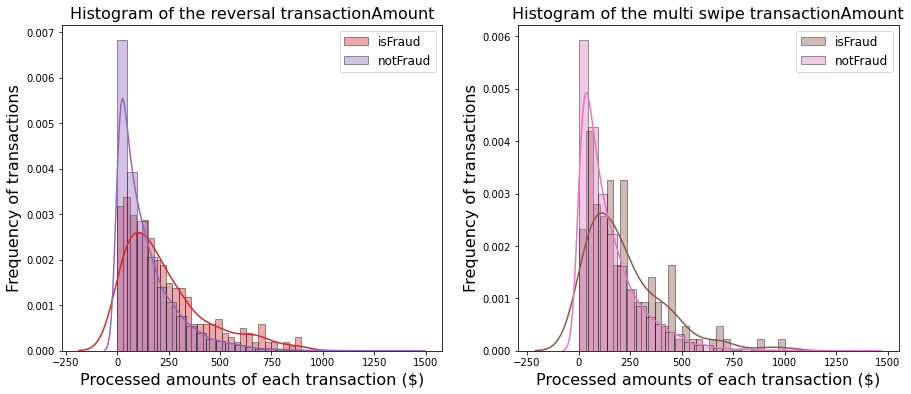

In [32]:
# visualize transactionAmount distributions with kind of transaction vs. isFraud
target_col = 'transactionAmount'
series_reversal_isFraud = df_reversal.loc[df_reversal.isFraud==True, target_col]
series_reversal_notFraud = df_reversal.loc[df_reversal.isFraud==False, target_col]
series_reversal = [series_reversal_isFraud, series_reversal_notFraud]

series_multi_swipe_isFraud = df_multi_swipe.loc[df_multi_swipe.isFraud==True, target_col]
series_multi_swipe_notFraud = df_multi_swipe.loc[df_multi_swipe.isFraud==False, target_col]
series_multi_swipe = [series_multi_swipe_isFraud, series_multi_swipe_notFraud]

# make subplot based on type of transaction
plt.figure(figsize=(15, 6))
for (i, series_tran), label in zip(enumerate([series_reversal, series_multi_swipe]), \
                                   ['reversal', 'multi swipe']):
    plt.subplot(1, 2, i+1)
    sns.distplot(series_tran[0], color=next(palette), hist=True, kde=True, 
             bins=30, hist_kws={'edgecolor':'black'}, label='isFraud')
    sns.distplot(series_tran[1], color=next(palette), hist=True, kde=True, 
             bins=30, hist_kws={'edgecolor':'black'}, label='notFraud')
    
    plt.xlabel("Processed amounts of each transaction ($)", size=16)
    plt.ylabel('Frequency of transactions', size=16)
    plt.legend(fontsize=12)
    plt.title(f'Histogram of the {label} transactionAmount', size=16)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


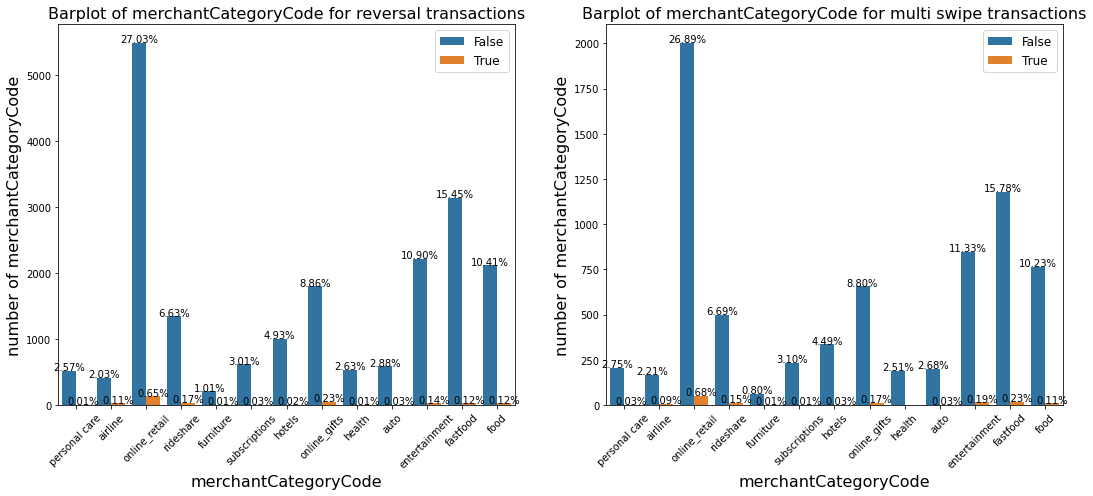

In [33]:
# visualize merchantCategoryCode barplots with kind of transaction vs. isFraud
target_col = 'merchantCategoryCode'
cats_reversal = list(set(df_reversal[target_col]))
cats_multi_swipe = list(set(df_multi_swipe[target_col]))
cats = [cats_reversal, cats_multi_swipe]
dfs = [df_reversal, df_multi_swipe]

# make barplots based on type of transaction
plt.figure(figsize=(18, 7))
for (i, df_i), cat, label in zip(enumerate(dfs), cats, ['reversal', 'multi swipe']):
    plt.subplot(1, 2, i+1)
    ax1 = sns.countplot(x=target_col, data=df_i, hue='isFraud', order=cat)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_xlabel('merchantCategoryCode', fontsize=16)
    ax1.set_ylabel('number of merchantCategoryCode', fontsize=16)
    plt.legend(fontsize=12)
    ax1.set_title(f'Barplot of merchantCategoryCode for {label} transactions' , fontsize=16)
    
    # add and show percents of each category
    for p in ax1.patches:
        height = p.get_height()
        ax1.text(p.get_x() + p.get_width()/2.,\
                 height + 3, '{:1.2f}%'.format(height/len(df_i)*100),\
                 ha='center', fontsize=10)

### Summary of Question 3: <a class="anchor" id="sub6"></a>

1. For reversed transactions:
    - There are a total of 20303 records identified as reversed transactions, with the total dollar amount = \$2821792.5.
    
    
2. For multi-swipe transactions:
    - There are a total of 7457 records identified as multi-swipe transactions, with the total dollar amount = \$1104006.71.
    
    
3. From the plot of transactionAmount distributions with kind of transaction versus isFraud label:
    - Fraud transactions showed wider distuibution than normal transactions, which means fraud transactions tend to take in the form of having relatively higher transaction amount.
    - Due to the wider distribution of transaction amount for multi-swipe transaction category, multi-swipe transactions with amount between \$150-500 have higher suspect to be identified as Fraud transactions.
    
    
4. From plot of merchantCategoryCode barplots with kind of transaction versus isFraud label:
    - The fraudulent rate of each merchant for both two type of transactions are pretty much similar. It's concluded that online retails has highest fraudulent rate among other merchant categories, with rate of 0.65\% and 0.68\% for reversed and multi-swipe transactions, respectively. 

## Question 4: Model <a class="anchor" id="fourth-bullet"></a>

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

### I: Feature Engineering <a class="anchor" id="sub7"></a>

**Summary of all 29 fields condition and the their weights**:
- The numerical features: `creditLimit`, `availableMoney`, `transactionAmount`, `currentBalance` -- 4/29.


- The boolen type features: `cardPresent`, `expirationDateKeyInMatch`, `isFraud` -- 3/29. 


- To-be-dropped features: `echoBuffer`, `merchantCity`, `merchantState`, `merchantZip`, `posOnPremises`, `recurringAuthInd` -- 6/29.


- Datetime type features: `dateOfLastAddressChange`, `currentExpDate`, `accountOpenDate`, `transactionDateTime` -- 4/29.


- String-to-numerical type features: `cardCVV`, `cardLast4Digits`, `enteredCVV` -- 3/29.


- Categorical features: `posConditionCode`, `merchantCountryCode`, `acqCountry`, `merchantCategoryCode`, `transactionType`, `posEntryMode` -- 6/29.


- Special features with many categories: `merchantName`, `accountNumber`, `customerId` --- 3/29.


**Based on all the EDA above, I suggest the following feature engineering strategies**:
1. Drop the 6 empty fields: `echoBuffer`, `merchantCity`, `merchantState`, `merchantZip`, `posOnPremises`, `recurringAuthInd`.


2. Fillna for the rest of 4 partially clean fields: `acqCountry`, `merchantCountryCode`, `posEntryMode`, `posConditionCode`.
    - Note that `transactionType` has already been filled with 'NaN' keywords in Question 3.
    
    
3. Transfer string format records to integer format records for: `cardCVV`, `cardLast4Digits`, `enteredCVV` and boolen type fields `cardPresent`, `expirationDateKeyInMatch`, `isFraud`.


4. Transfer all the object features related with datetime: `dateOfLastAddressChange`, `currentExpDate`, `accountOpenDate`, `transactionDateTime` to new numerical features.
    - Note that `transactionDateTime` has been transferred to standard datetime format in Question 3.
    
    
5. Feature reconstruction on object features: `merchantName`, `accountNumber`, `customerId`.
    - Since these field has too many categories, I'll reconstruct these features by counting the number of records labeled as Fraud for each category of these fields.


6. Perform one-hot-encoding on all categorical features.


7. Drop all the old (before feature engineering) or duplicated (cause of multicolinearity) fields.

In [34]:
# make a copy of original df for feature engineering
df_clean = df.copy()

In [35]:
# task 1: Drop the 6 empty fields (fields 29 -> 23)

df_clean = df_clean.drop(fields_all_mv_list, axis=1)
print(f"Current number of fields = {df_clean.shape[1]}")

Current number of fields = 23


In [36]:
# task 2: Fillna for the rest of 4 partially clean fields

for field in ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode']:
    df_clean[field] = df_clean[field].fillna('NaN')

In [37]:
# task 3: Transfer string and bool format records to integer format

for field in ['cardCVV',  'cardLast4Digits', 'enteredCVV']:
    df_clean[field] = df_clean[field].astype(int)
    
for field in ['cardPresent', 'expirationDateKeyInMatch', 'isFraud']:
    df_clean[field] = df_clean[field].astype(int)

In [38]:
# task 4: Processing on DateTime fields (fields 23 -> 32)

# processing the DateTime fields to standard year-month-day datetime format
df_clean['dateOfLastAddressChange'] = df_clean['dateOfLastAddressChange'].apply( \
    lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_clean['currentExpDate'] = df_clean['currentExpDate'].apply( \
    lambda x: datetime.strptime(x, '%m/%Y'))
df_clean['accountOpenDate'] = df_clean['accountOpenDate'].apply( \
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

# with the same format:
# convert transactionDateTime into six numerical feature 'transactionMonth', 'transactionDay', 'transactionWDay',
# 'transactionHour', 'transactionMin', 'transactionSec'
df_clean['transactionMonth'] = df_clean['transactionDateTime'].dt.month
df_clean['transactionDay'] = df_clean['transactionDateTime'].dt.day
df_clean['transactionWDay'] = df_clean['transactionDateTime'].dt.weekday
df_clean['transactionHour'] = df_clean['transactionDateTime'].dt.hour
df_clean['transactionMin'] = df_clean['transactionDateTime'].dt.minute
df_clean['transactionSec'] = df_clean['transactionDateTime'].dt.second

# next, use the day of transactionDateTime as a basetime to transfer other date fields
# convert dateOfLastAddressChange into new feature 'diffLastAddressChange'
df_clean['diffLastAddressChange'] = (df_clean['transactionDateTime'] - df_clean['dateOfLastAddressChange' \
                                                                               ]).dt.days

# convert currentExpDate into new feature 'diffExpDate'
df_clean['diffExpDate'] = (df_clean['currentExpDate'] - df_clean['transactionDateTime']).dt.days

# convert accountOpenDate into new feature 'diffOpenDate'
df_clean['diffOpenDate'] = (df_clean['transactionDateTime'] - df_clean['accountOpenDate']).dt.days

In [39]:
# task 5-1: reconstruct the merchantName, accountNumber, customerId fields (fields 32 -> 33)

# for merchantName field
fields = ['merchantName','isFraud']
# group by counting isFraud numbers
merchant_group = df_clean.groupby(fields).size().reset_index(name='merchantFraudCount')
# select merchant_group with isFraud label
merchant_group_fraud = merchant_group.loc[(merchant_group.isFraud==True) &
                                         (merchant_group.merchantFraudCount>0)]
# drop the isFraud column 
merchant_group_fraud = merchant_group_fraud.drop(['isFraud'], axis=1)
# merge with the merchant_group_fraud df with df_clean
df_clean = pd.merge(merchant_group_fraud, df_clean, how='outer', on=['merchantName'])

# fillna for the records with NaN merchantFraudCount
df_clean.merchantFraudCount = df_clean.merchantFraudCount.fillna(0)

In [40]:
# task 5-2: reconstruct the merchantName, accountNumber, customerId fields (fields 33 -> 34)
# for accountNumber and customerId fields

# check this these two fields are actuallly identical
print(sum(df_clean['accountNumber'] == df_clean['customerId'])/len(df_clean))

1.0


**My comment**: I'll ignore the `accountNumber` field since it is exactly the same as `customerId field`, will drop this field later.

In [41]:
# perform the same reconstruction as for merchantName
fields = ['customerId','isFraud']
# group by counting isFraud numbers
customerId_group = df_clean.groupby(fields).size().reset_index(name='customerIdFraudCount')
# select customerId_group with isFraud label
customerId_group_fraud = customerId_group.loc[(customerId_group.isFraud==True) & 
                                              (customerId_group.customerIdFraudCount>0)]
# drop the isFraud column 
customerId_group_fraud = customerId_group_fraud.drop(['isFraud'], axis=1)
# merge with the customerId_group_fraud df with df_clean
df_clean = pd.merge(customerId_group_fraud, df_clean, how='outer', on=['customerId'])

# fillna for the records with NaN merchantFraudCount
df_clean.customerIdFraudCount = df_clean.customerIdFraudCount.fillna(0)

In [42]:
# task 6: Perform one-hot-encoding on all categorical features (fields 34 -> 77)

cat_fields = ['posConditionCode', 'merchantCountryCode', 'acqCountry', 'merchantCategoryCode', 
              'transactionType', 'posEntryMode']  # six fields
# get dummy features
df_dummy = pd.get_dummies(df_clean[cat_fields])
print(f"Number of dummy features = {df_dummy.shape[1]}.")

# concatenate the dummy df with df_clean
df_clean = pd.concat([df_dummy, df_clean], axis=1)

Number of dummy features = 43.


In [43]:
# task 7: Drop all the old or duplicated (cause of multicolinearity) fields (fields 77 -> 64)

# fields to be dropped
fields_drop = ['transactionDateTime', 'dateOfLastAddressChange', 'currentExpDate', 'accountOpenDate',
              'merchantName', 'accountNumber', 'customerId'] + cat_fields
# drop the fields
df_clean = df_clean.drop(fields_drop, axis=1)

In [44]:
# show the df after feature engineering
df_clean.head()

,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_NaN,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_NaN,merchantCountryCode_PR,merchantCountryCode_US,acqCountry_CAN,acqCountry_MEX,acqCountry_NaN,acqCountry_PR,acqCountry_US,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_NaN,transactionType_PURCHASE,transactionType_REVERSAL,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posEntryMode_NaN,customerIdFraudCount,merchantFraudCount,creditLimit,availableMoney,transactionAmount,cardCVV,enteredCVV,cardLast4Digits,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionMonth,transactionDay,transactionWDay,transactionHour,transactionMin,transactionSec,diffLastAddressChange,diffExpDate,diffOpenDate
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,13.0,50000.0,49953.81,200.12,546,546,4615,46.19,1,0,0,4,8,4,19,56,36,820,4831,820
1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0,22.0,50000.0,49929.31,95.11,402,402,2077,70.69,1,0,0,11,9,2,7,26,6,1035,1603,1035
2,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0,7.0,50000.0,49996.04,5.26,546,546,4615,3.96,1,0,0,5,6,4,2,54,1,848,6264,848
3,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.0,8.0,50000.0,49933.93,141.60,546,546,4615,66.07,1,0,0,2,3,2,4,48,54,755,5384,755
4,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1.0,20.0,50000.0,50000.00,304.15,546,546,4615,0.00,1,0,0,6,3,4,18,50,55,876,5994,876


**My comment**: Update this stage, all feature engineering is done, and the dataset is ready to be used to build a machine learning (classification) model to predict fraud transactions.

### II: Build the classification model -- XGBoost <a class="anchor" id="sub8"></a>

**Summary of the predictive model building strategies**:
1. Train-test split:
    - Make 80% of data as training set and 20% data as test set.
    - In training set, leave 20% of data as validation set.
    
    
2. About resampling on highly imbalanced dataset, as I have mentioned in $\textbf{Question 1}$, the samples in this dataset is extremely imbalanced:
    
|   isFraud$=False$  | isFraud$=True$ |
|--------------------------|-----------------------|
|    98.42%               | 1.58%                |

Therefore, I considered mainly $2$ resampling methods to deal with this problem: 
    - Over-Sampling (a.k.a. SMOTE)
    - Under-Sampling

Theoretically, I'll perform both Under-Sampling and SMOTE for resampling, and select the resampling method that achieve the best performance on the test sets. However, since for Over-Sampling(SMOTE), I need to fit more data which could cost much more time than Under-Sampling, therefore, I choose to use Under-Sampling in this project.


3. Regarding to the choice of classification model in this data challenge, comparing with widely used models like logistic regression (usually as a baseline model), Random Forest, and DNNs, tree model still has some advantages due to its simple structure and explainable decision process. Especially for tabular data, gradient boosted decision trees (GBDT) models usually have better accuracy than deep networks, which is verified by many Kaggle competitions and real applications. Since the `XGBoost` framework is designed to be highly efficient, flexible and portableThus, I choose to use `XGBoost` for the classification task. 


4. For the optimization of the model hyperparameters, there are many algorithms and choices, e.g. grid search. However, I use the `Optuna` optimization framework for this classification model. `Optuna` uses Bayesian methods to search the model hyperparameters that yield the best score on the validation set metric, and works perfect with GPU environment with `XGBoost`. 


5. About the model evaluation metrices
    - Accuracy: accuracy classification score
    - Recall: evaluate the ability of the classifier to find all the positive samples
    - Rrecision: evaluate the ability of the classifier not to label as positive a sample that is negative
    - Roc-Auc score: compute Area Under the Receiver Operating Characteristic Curve (ROC-AUC) from prediction scores
    - ROC curve (receiver operating characteristic curve) and AUC (Area under the ROC Curve)


6. The whole workflow as follows:

<font color="blue">
\begin{equation}
\begin{matrix}
\text{Split the sets into "Train" and "Test"}&
\mathop{\longrightarrow}\limits^{\text{Store }\textbf{Test}\text{ for later use}}
    & \textbf{Train} & \longrightarrow &\text{Create 5 trials in optuna} \\
& & & &\downarrow\\
& & & &\text{5 times iteration:}\\
\textbf{Train}&& \textbf{validation}_k & \longleftarrow & \text{each time fit on validation set}\\
\text{Using Under-Sampling}&&&&\downarrow\\
\text{fit}\downarrow&&\downarrow&&\textbf{train}_k \\
\textbf{Model} \text{ with tuned parameters}&\mathop{\longleftarrow}\limits_{\text{Select Hyperparameters}}^{\text{Finish Iteration}}&\text{get } \textbf{Model}_k\text{ and search best hyperparameters}
&\mathop{\longleftarrow}\limits^{\text{Model Fitting}}&\text{Using Under-Sampling}\\
    \downarrow\\
    \text{use }\textbf{Test}\text{ set to evaluate the model}\\
\end{matrix}
\end{equation}
</font>

Due to the limited time:
- I'll only use `XGBoost` as the predictive model for the task. 
- I'll ignore the K-fold training-validation cross-validation.

In [45]:
# part 1: train-test split for building model

# split the clean df into feature matrix X and target y
feature_list = list(set(df_clean.columns) - {'isFraud'})
X = df_clean[feature_list]
y = df_clean['isFraud']

# standardize the features on training set
stand = StandardScaler()
stand.fit(X)
X = stand.transform(X)

# perform train-test split
X_train_whole, X_test, y_train_whole, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_whole, y_train_whole, 
                                                      stratify=y_train_whole, test_size=0.2)
print(f"Training set size = {X_train.shape[0]}.")
print(f"Validation set size = {X_valid.shape[0]}.")
print(f"Test set size = {X_test.shape[0]}.")

Training set size = 503272.
Validation set size = 125818.
Test set size = 157273.


In [46]:
# Created the Xgboost specific DMatrix data format from the numpy array to optimise memory consumption

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_list, missing=np.NAN)
dvalid = xgb.DMatrix(X_valid, label=y_valid, feature_names=feature_list, missing=np.NAN)

In [47]:
def objective(trial):
    """Define the objective function to be optimized; Perform hyperparameters search 
    using valid set by XGBoost framewrok
    Params:
        trial: suggest hyperparameter values using trial object
    return:
        accuracy: accuracy classification score
    """
    # specify the search space that XGBoost hyperparameters to be tuned
    tree_method = ['exact','approx','hist','gpu_hist']
    boosting_list = ['gbtree', 'gblinear']
    objective_list_reg = ['reg:squarederror', 'reg:gamma', 'reg:tweedie', 'binary:logistic']
    metric_list = ['rmse']
    # create parameter dict
    params = {
        'boosting':trial.suggest_categorical('boosting', boosting_list),
        'tree_method':trial.suggest_categorical('tree_method', tree_method),
        'eval_metric':trial.suggest_categorical('eval_metric', metric_list),
        'objective':trial.suggest_categorical('objective', objective_list_reg),
        'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
        'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
        'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'colsample_bynode':trial.suggest_discrete_uniform('colsample_bynode', 0.1, 1, 0.01),
        'colsample_bylevel':trial.suggest_discrete_uniform('colsample_bylevel', 0.1, 1, 0.01),
        'gamma': trial.suggest_int('gamma', 0, 10),
    }
    # train xgboost classifier using training set and predict on valid set
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    
    # evaluate trials based on their accuracy on the valid set
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy

In [48]:
# create a study object and invoke the optimize method over 5 trials
study = optuna.create_study()
study.optimize(objective, n_trials=5)

print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-02-02 00:43:46,653] A new study created in memory with name: no-name-8805a617-96b8-4409-bc7f-2ab216e307f1
[I 2021-02-02 00:44:04,824] Trial 0 finished with value: 0.9842232430971721 and parameters: {'boosting': 'gblinear', 'tree_method': 'exact', 'eval_metric': 'rmse', 'objective': 'reg:tweedie', 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 1, 'n_estimators': 12, 'max_depth': 12, 'learning_rate': 0.02425281877292949, 'subsample': 0.5494985367442801, 'colsample_bytree': 0.7930884658366204, 'colsample_bynode': 0.62, 'colsample_bylevel': 0.98, 'gamma': 6}. Best is trial 0 with value: 0.9842232430971721.
[I 2021-02-02 00:44:28,607] Trial 1 finished with value: 0.9842073471204438 and parameters: {'boosting': 'gbtree', 'tree_method': 'approx', 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 4, 'n_estimators': 39, 'max_depth': 7, 'learning_rate': 0.0882586700747469, 'subsample': 0.6355842860194663, 'colsample_bytree'

Best trial: score 0.9842073471204438, params {'boosting': 'gbtree', 'tree_method': 'approx', 'eval_metric': 'rmse', 'objective': 'reg:squarederror', 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 4, 'n_estimators': 39, 'max_depth': 7, 'learning_rate': 0.0882586700747469, 'subsample': 0.6355842860194663, 'colsample_bytree': 0.7354879305454848, 'colsample_bynode': 0.87, 'colsample_bylevel': 0.83, 'gamma': 7}


In [49]:
# get the optimized hyperparameters grid
best_params = study.best_trial.params
# fit the XGBoost classifier with optimal hyperparameters
clf = xgb.XGBClassifier(**best_params)

In [50]:
# perform Under-Sampling on the whole traning set

rus = RandomUnderSampler()
X_train_resample, y_train_resample = rus.fit_sample(X_train, y_train)
counter = Counter(y_train_resample)
print(f"After the resampling, the resampled condition in train label set = {counter}.")

After the resampling, the resampled condition in train label set = Counter({0: 7947, 1: 7947}).


In [51]:
%time clf.fit(X_train_resample, y_train_resample)  # use the training data

CPU times: user 3.85 s, sys: 5.03 ms, total: 3.85 s
Wall time: 3.85 s


XGBClassifier(base_score=0.5, booster='gbtree', boosting='gbtree',
              colsample_bylevel=0.83, colsample_bynode=0.87,
              colsample_bytree=0.7354879305454848, eval_metric='rmse', gamma=7,
              learning_rate=0.0882586700747469, max_delta_step=0, max_depth=7,
              min_child_weight=4, missing=None, n_estimators=39, n_jobs=1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=2, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6355842860194663, tree_method='approx',
              verbosity=1)

In [52]:
# define helper function for model evaluation

def evaluate_clf_model(model, X_test, y_test, label, verbose=True):
    """Help function to define evaluation metrices: scores and plots
    Params:
        model: the trained classification model
        X_test: test feature set
        y_test: test label set
        label: name of the classification model
    Return:
        accu_score: accuracy classification score
        recall: evaluate the ability of the classifier to find all the positive samples
        precision: evaluate the ability of the classifier not to label as positive a sample that is negative
        roc_auc: compute Area Under the Receiver Operating Characteristic Curve (ROC-AUC) from prediction scores
    """
    # compute clf model scores
    score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, threshs = roc_curve(y_test, score)
    y_pred = model.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, score)
    
    # draw the ROC-AUC curve
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    plt.plot(fpr, tpr, label=label, alpha=0.6)
    plt.plot([0, 1], [0, 1], 'k--', label='reference')
    plt.legend(fontsize=12)
    plt.title(f'ROC curve of {label} classifier on test set', size=16)
    plt.xlabel('FPR', size=16)
    plt.ylabel('TPR', size=16)
    plt.show()

    if verbose:
        print('--------- Results for XGBClassifier ---------')
        print(f"Accuracy score on test set = {accu_score}.")
        print(f"Recall score on test set = {recall}.")
        print(f"Precision score on test set = {precision}.")
        print(f"ROC-AUC score on test set = {roc_auc}.")

    return accu_score, recall, precision, roc_auc

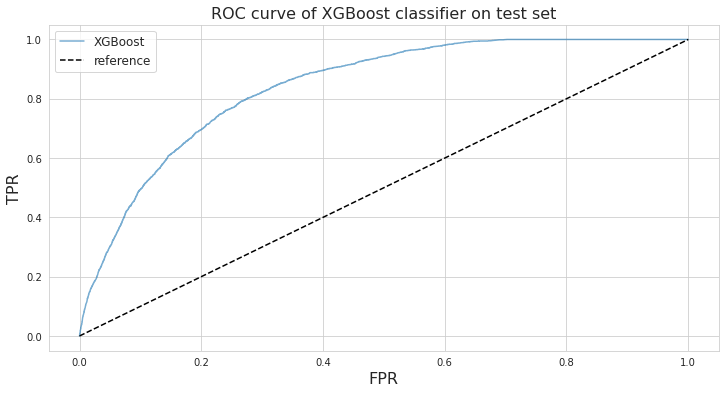

--------- Results for XGBClassifier ---------
Accuracy score on test set = 0.6988039905133112.
Recall score on test set = 0.8252114377768828.
Precision score on test set = 0.041829131366744925.
ROC-AUC score on test set = 0.8402131665686511.


In [53]:
# report clf model evaluation metrices

accu_score_xgb, recall_xgb, precision_xgb, roc_auc_score_xgb = evaluate_clf_model(clf, X_test, y_test, 'XGBoost')

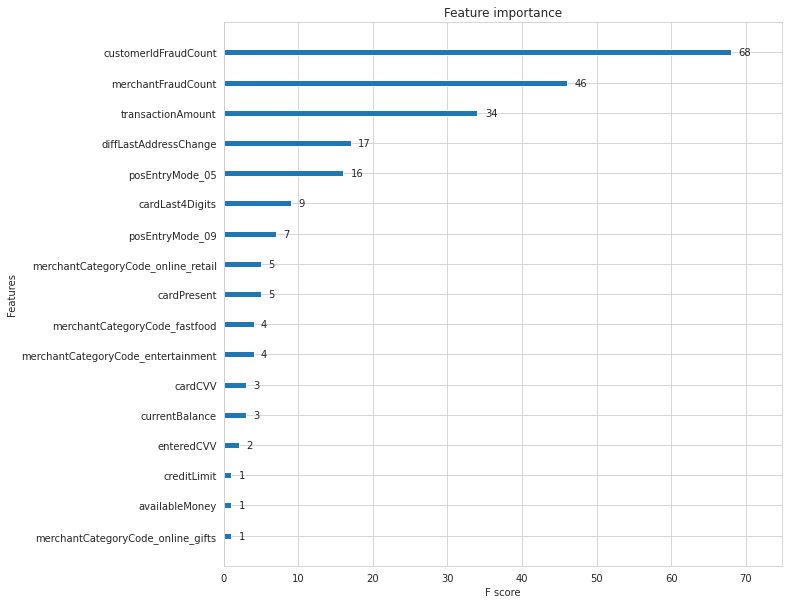

In [54]:
# plot the top 20 feature importances

fig, ax = plt.subplots(1,1,figsize=(10, 10))
clf.get_booster().feature_names = feature_list
xgb.plot_importance(clf.get_booster(), max_num_features=20, ax=ax)

In [55]:
# save model
# clf.save(f'transaction_fraud_clf_model.h5')

### Summary of Question 4: <a class="anchor" id="sub9"></a>

1. In this section, I build a XGBoost classifier to predict the fraud transactions with deliberate design of feature engineering. All the related model adjustments were provided as `part II: Build the classification model -- XGBoost`. 


2. With the optimized classification model, the evaluation summary is:
    - Accuracy score on test set = 0.6988
    - Recall score on test set = 0.8252
    - Precision score on test set = 0.0418
    - ROC-AUC score on test set = 0.8402

Based on the metrices above, it might implies that my trained classifier achieves the good performance on the positive class with high AUC, but at the cost of a high false negatives rate (or a low number of true negative).


3. Based on the feature importance plot, it's clearly showed that the two reconstructed features (`customerIdFraudCount`, `merchantFraudCount`) together contribute the most to the classification of fraud transactions. In addition, it also implies that transaction amount, address change since transaction day, some pos-entry modes, and cards last 4 digits could be highly associated features regarding to  fraud transactions.

## Appendix of Question 4: Future work <a class="anchor" id="fifth-bullet"></a>

There are a few additional data analysis and modeling details that I think will improvement the whole workflow:

1. Due to the time limit, I didn't implement K-fold cross validation of the XGBoost framework into the model pipeline. To deal with the extremely imbalance data, I'll suggest using the function ``StratifiedKFold`` in ``model_selection`` to ensure that the Train and Test data sets inherit the proportion 1.58% "$\text{isFraud}=True$" from the dataset.


2. It's usually necessary to build a baseline classification model (e.g. logistic regression) before design more complicated models (e.g. XGBoost or DNNs). By tuning on baseline model, we can gain more understanding about the model parameters (e.g. threshold between recall and precision in this case) to provide guidance for next modeling.


2. An rigorous approach to test existance of multicolinearity in the datset should be added. For example, the field `creditLimit` is highly correlated with `currentBalance` and `availableMoney`, this relation need be the cause of multicolinearity. 


3. Information of `cardCVV` and `enteredCVV` can provide additional insights for classification of fraud transaction. Since for records with dismatched cardCVV and enteredCVV, it's of suspect that those transactions could be fraudulent. 


4. Since we have four datetime-related features, it'll insightful to analyze the relations between fraud transactions are during specific time/day periods. With more data about credit transaction, It's recommanded to perform time-series analysis to detect time slots with high-risk of fraud transactionsare.